## FX Election Hedge
### Summary 

With the US election less than 40 days away, election market dynamics are a major risk driver across asset classes. In this note, we look for interesting FX proxies for different election outcomes and find that AUDJPY has a strong relationship to and a higher beta to SPX in downside scenarios than in upside ones, making it a potentially attractive downside hedge. We use `gs-quant` to examine the relationship, price several structures and analyze impact of different election outcomes on these trades.

The content of this notebook is split into:
* [1 - Let's get started with gs quant](#1---Let's-get-started-with-gs-quant)
* [2 - State of FX market](#2---State-of-FX-market)
* [3 - Downside sensitivity to SPX](#3---Downside-sensitivity-to-SPX)
* [4 - Structures](#4---Structures)
* [5 - Pricing election outcomes](#5---Pricing-election-outcomes)
* [What's New](#What's-New)

P.S. In case you missed it, [check out the replay of our last webinar](https://developer.gs.com/docs/gsquant/videos/gs-quant-meets-markets/) where our traders and strats use code as content to comment on macro trends, in particular around US elections.

### 1 - Let's get started with gs quant
Start every session with authenticating with your unique client id and secret. If you don't have a registered app, create one [here](https://marquee.gs.com/s/developer/myapps/register). `run_analytics` scope is required for the functionality covered in this example. Below produced using gs-quant version 0.8.199.

In [1]:
from gs_quant.session import GsSession
GsSession.use(client_id=None, client_secret=None, scopes=('run_analytics', 'read_product_data')) 

### 2 - State of FX market

Let's focus on G10 and grab spot and vol data from [gs data catalog](https://marquee.gs.com/s/discover/data-services/catalog). To start, let's see how things have evolved over the last few months - we'll use the longer history in latter parts of the analysis.

In [2]:
from gs_quant.data import Dataset
import pandas as pd
import datetime

start_date = datetime.date(2005, 8, 26)
end_date = datetime.date.today()

fx_pairs = ['USDJPY', 'EURUSD', 'AUDUSD', 'AUDJPY', 'USDNOK', 'GBPUSD','USDCAD', 'NZDUSD', 'USDSEK', 'USDCHF']

fx_spot = Dataset('FXSPOT_PREMIUM').get_data(start_date, end_date, bbid=fx_pairs, location='NYC')
fx_spot = pd.pivot_table(fx_spot, values='spot', index=['date'], columns=['bbid'])

fx_vol = Dataset('FXIMPLIEDVOL_PREMIUM').get_data(start_date, end_date, bbid=fx_pairs, tenor='3m', deltaStrike='DN', location='NYC')
fx_vol = pd.pivot_table(fx_vol, values='impliedVolatility', index=['date'], columns=['bbid'])

spx_spot = Dataset('TREOD').get_data(start_date, end_date, bbid='SPX')[['closePrice']].rename(columns = {'closePrice':'SPX'})

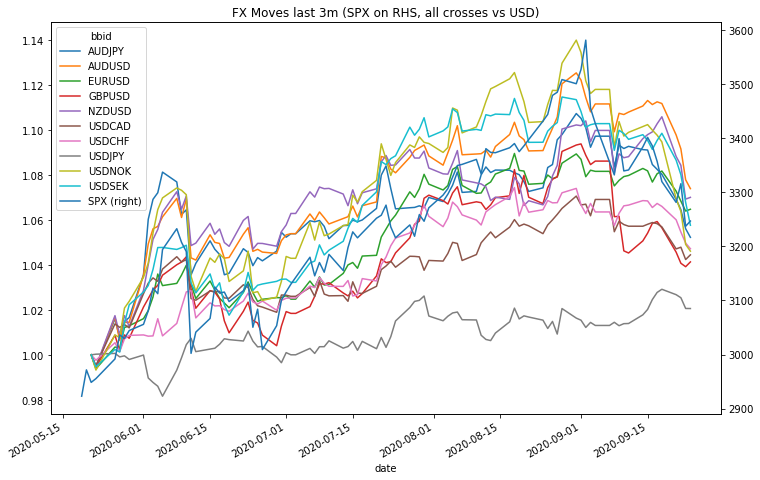

In [36]:
last3m = fx_spot.tail(90).apply(lambda x: 1/x if x.name[:3]=='USD' else x)
ax = (last3m / last3m.iloc[0]).plot(figsize=(12, 8), title='FX Moves last 3m (SPX on RHS, all crosses vs USD)')
spx_spot.tail(90).plot(secondary_y=True, ax=ax)

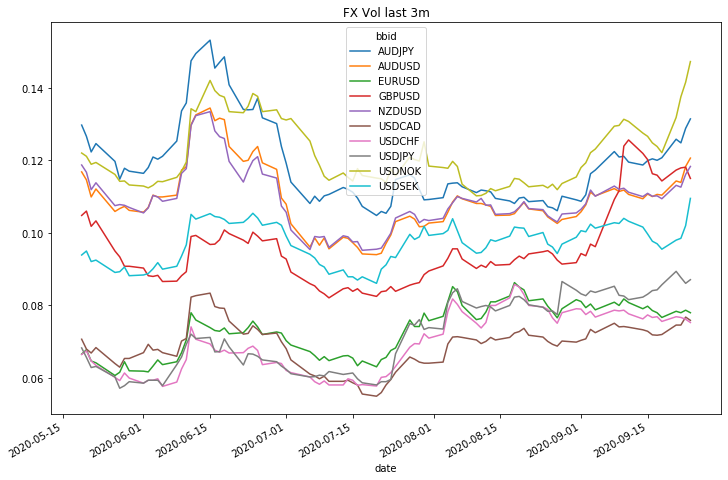

In [34]:
fx_vol.tail(90).plot(figsize=(12, 8), title='FX Vol last 3m')

USD has weakened relative to the major currencies over the first 2 months of the period but strengthened most recently. Looking to the vol space, 3m vols peaked first half of June, normalizing slightly over next few months but have started to climb again most recently. Let's see their z scores to see how many standard deviations they are away from the mean on a 1, 3, 6, 9 month basis.

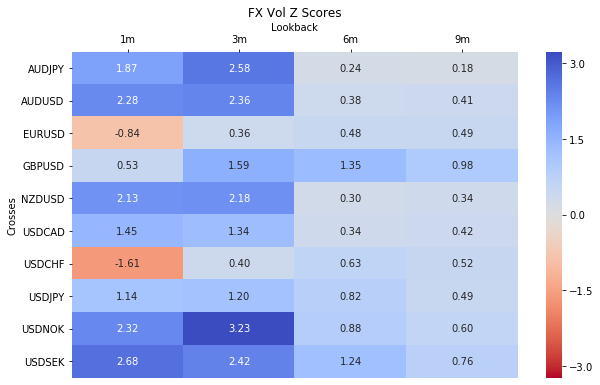

In [50]:
from gs_quant.timeseries import beta, returns, diff, zscores
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

zs = lambda p, d: zscores(d.tail(p)).tail(1).values[0]
fx_vol_zs = {cross: {'1m': zs(21, data), '3m': zs(63, data), '6m': zs(126, data), 
                     '9m': zs(189, data)} for cross, data in fx_vol.iteritems()}

def plot_crosses(data, xlabel, title):
    plt.subplots(figsize=(10, 6))
    center = max(data.max().max(), abs(data.min().min())) 
    ax = sns.heatmap(data, annot=True, vmin=-center, vmax=center, fmt='.2f', cmap='coolwarm_r', )
    ax.set(ylabel='Crosses', xlabel=xlabel, title=title)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

plot_crosses(pd.DataFrame(fx_vol_zs).T, xlabel='Lookback', title='FX Vol Z Scores',)

### 3 - Downside sensitivity to SPX

Although many parts of the market recovered much of the lost ground since the start of the pandemic, as we can see above, a skittish environment remains. Given an abundance of potential downside catalysts and elections on the horizon, it's no surprise implied volatility in FX and especially in equity markets where investors are looking to downside protection, remains high. 

Let's look at the relationship of the crosses we examined so far to SPX returns especially in drawdown scenarios to see if we can find FX alternatives with a high SPX beta but potentially lower cost.

# of observations for SPX -0.1: 3
# of observations for SPX -0.05: 20
# of observations for SPX 0.05: 15
# of observations for SPX 0.1: 5


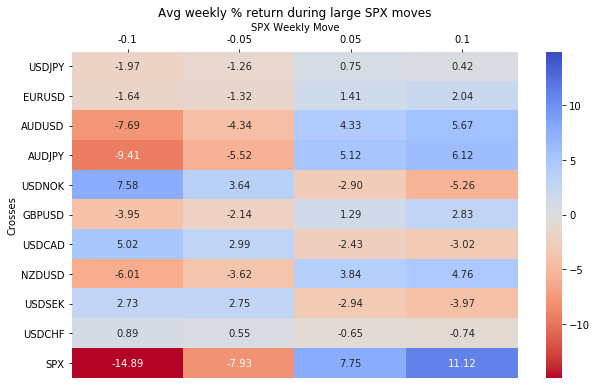

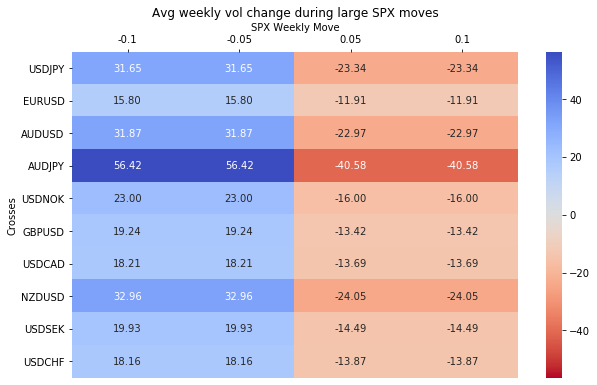

In [65]:
from collections import defaultdict

def package_data(data, freq='W-FRI', abs_c=False, w=1):
    spt_data = pd.concat([data, spx_spot], axis=1)
    sampled = spt_data.resample(freq).last()
    return diff(sampled, w).dropna() if abs_c else returns(sampled, w).dropna()
    
def perf_vs_spx(spx_returns, data, show_ret=False):
    avg_p = defaultdict(dict)
    for ret in spx_returns:
        dns = data[data.SPX <= ret].dropna() if ret < 0 else data[data.SPX >= ret].dropna() 
        for cross in fx_pairs:
            avg_p[ret][cross] = dns[cross].mean() * 100
        if show_ret:
            avg_p[ret]['SPX'] = dns.SPX.mean() * 100
            print(f'# of observations for SPX {ret}: {len(dns)}')
    return pd.DataFrame(avg_p)

spx_returns = [-.1, -.05, .05, .1]   
spot_perf = perf_vs_spx(spx_returns, package_data(fx_spot), show_ret=True)
vol_perf = perf_vs_spx(spx_returns, package_data(fx_vol, abs_c=True)*100)

plot_crosses(spot_perf, 'SPX Weekly Move', 'Avg weekly % return during large SPX moves')
plot_crosses(vol_perf, 'SPX Weekly Move', 'Avg weekly vol change during large SPX moves')

As we can see above AUDJPY and AUDUSD moved with the largest magnitude in the same direction with as SPX when SPX experienced large moves since the start date (2005 in this case). Instead of looking at returns, let's focus on one of the crosses - AUDJPY - and look at the conditional relationship through a different lens: the R-squared number on each chart will tell us the strength of the relationship with numbers closer to 0 indicating a lack of one.

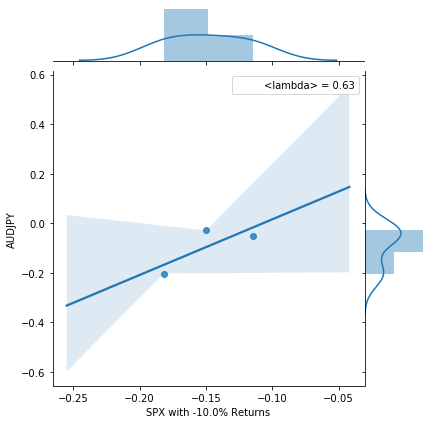

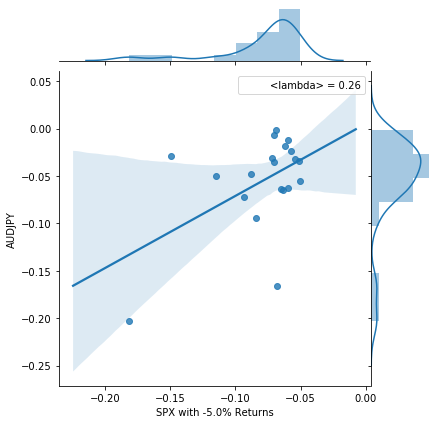

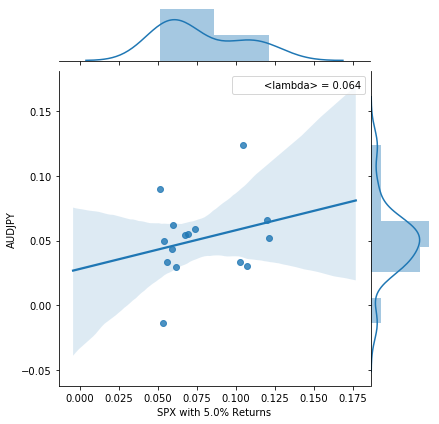

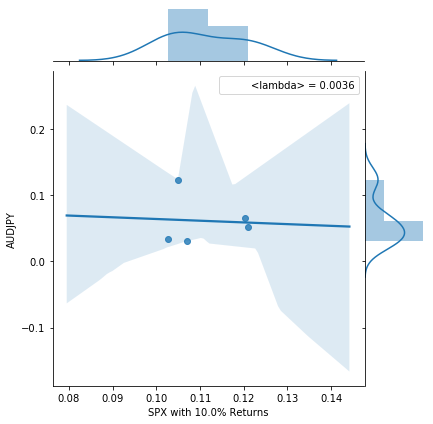

In [10]:
from scipy import stats

r2 = lambda x,y: stats.pearsonr(x,y)[0]**2 

def SPX_conditional_downside(thresholds, data, asset):
    for ret in thresholds:
        dns = data[data.SPX <= ret].dropna() if ret < 0 else data[data.SPX >= ret].dropna() 
        j = sns.jointplot(x='SPX', y=asset, data=dns, kind='reg')
        j.set_axis_labels('SPX with {}% Returns'.format(ret*100), asset)
        j.fig.subplots_adjust(wspace=.02)
        plt.show()

spot_package = package_data(fx_spot)
SPX_conditional_downside(spx_returns, spot_package, 'AUDJPY')

As we can see from the charts above, there's a strong positive relationship between AUDJPY and SPX in large downside scenarios (SPX -5% and -10% on the week) but not on the upside (SPX +5%, +10%). This makes this cross an attractive candidate for an alternative to hedging with SPX directly.

### 4 - Structures

Let's now look at a few AUDJPY structures as potential hedges:

*  Buy 2m AUDJPY put using spx beta to size. Max loss limited to premium paid.
*  Buy 2m AUDJPY put spread (5.4%/10% OTMS). Max loss limited to premium paid.

For more info on these trades, reach out to receive the piece from our marketstrats team. Note all pricing is based on GS T-1 mid marks and does not include transaction costs.

We'll start by looking at the cost of an 10% OTMS SPX put (max loss limited to premium paid).

In [13]:
from gs_quant.instrument import EqOption, FXOption

spx = EqOption(option_type='Put', underlier='.SPX', exchange='NYSE', strike_price='90%', expiration_date='2m', buy_sell='Buy')
spx.resolve()

notional = spx.strike_price * spx.multiplier
print('cost in bps: {:,.2f}'.format(-spx.premium/notional * 1e4))
print('cost in USD: {:,.2f}'.format(-spx.premium))

cost in bps: -194.79
cost in USD: -5,674.34


Now, I will calculate the beta  over the last 6m and use that to size the FX hedge.

In [14]:
#buy 4m AUDJPY put
b = beta(fx_spot.AUDJPY.resample('W-FRI').last(), spx_spot.SPX.resample('W-FRI').last(), 4 * 6).tail(1).values[0]
beta_notional = notional * (1 / b)
audjpy_put = FXOption(option_type='Put', pair='AUDJPY', strike_price= f's-{b * 10}%', notional_amount=beta_notional, expiration_date='2m', buy_sell='Buy')
audjpy_put.resolve()
print('cost in bps: {:,.2f}'.format(audjpy_put.premium / audjpy_put.notional_amount * 1e4))
print('cost in USD: {:,.2f}'.format(audjpy_put.premium))

cost in bps: -68.67
cost in USD: -3,686.24


In [15]:
print('Discount to SPX: {:,.2f}%'.format((1 - audjpy_put.premium/-spx.premium) * 100))

Discount to SPX: 35.04%


We can cheapen the structure further by structuring a put spread.

In [27]:
from gs_quant.markets.portfolio import Portfolio

put1 = FXOption(option_type='Put', pair='AUDJPY', strike_price= f's-{b * 10}%', expiration_date='2m', notional_amount=beta_notional, buy_sell='Buy')
put2 = FXOption(option_type='Put', pair='AUDJPY', strike_price='s-10%', expiration_date='2m', notional_amount=beta_notional, buy_sell='Sell')
print('cost in USD: {:,.2f}'.format(put1.premium + put2.premium))

cost in USD: -2,323.98


In [17]:
print('Discount to put: {:,.2f}%'.format(100 - (put1.premium + put2.premium)/audjpy_put.premium * 100))

Discount to put: 36.96%


### 5 - Pricing election outcomes

Now, let's take this a step further and examine how different potential election outcomes might impact our put spread structure. First, we'll look at FXDelta to see which market assets are driving risk. Then, we'll carry our structure up to the election date and leverage work done by spot trading desk to shock the market assets we have risk to, examining PV impact of these carry + shock scenarios for various election outcomes. Note, here I'm using spot shocks only but you can additionally add vol shocks (example in comment below) for a more representative scenario. 

In [18]:
from gs_quant.risk import FXDelta

fx_package = Portfolio((put1, put2))
fx_package.resolve()
fx_package.calc(FXDelta).aggregate()

,mkt_type,mkt_asset,mkt_class,mkt_point,value
0,FX,JPY/USD,SPOT,,-328.913540
1,FX,USD/AUD,SPOT,,-48670.946463


In [21]:
from gs_quant.risk import CarryScenario, MarketDataPattern, MarketDataShock, MarketDataShockBasedScenario, MarketDataShockType
from gs_quant.markets import PricingContext

scenarios = pd.DataFrame({
    'AUDUSD': {'Rep sweep': 2.5, 'Trump + split congress': 2.0, 'Biden + split congress': -2.5, 'Dem sweep': -3.5, 'Still contested': -1.5},
    'USDJPY': {'Rep sweep': 2.0, 'Trump + split congress': 1.0, 'Biden + split congress': -2.5, 'Dem sweep': -3.5, 'Still contested': -2.5}
})

carry_scenario = CarryScenario(date = datetime.date(2020, 11, 3))
base_price = fx_package.price().aggregate()

outcomes = {}
with PricingContext(is_batch=True):
    for scenario, data in scenarios.iterrows():
        market_shock = MarketDataShockBasedScenario(shocks={  
            MarketDataPattern('FX', 'USD/AUD'): MarketDataShock(MarketDataShockType.Proportional, data.AUDUSD/100),
            MarketDataPattern('FX', 'JPY/USD'): MarketDataShock(MarketDataShockType.Proportional, data.USDJPY/100), 
            # note - you can easily add additional shocks here - like vol 
            # MarketDataPattern('FX Vol', 'JPY/AUD', 'ATM Vol'): MarketDataShock(MarketDataShockType.Absolute, x/100)
        })
        with carry_scenario, market_shock:
            s_p = fx_package.price()
        outcomes[scenario] = s_p

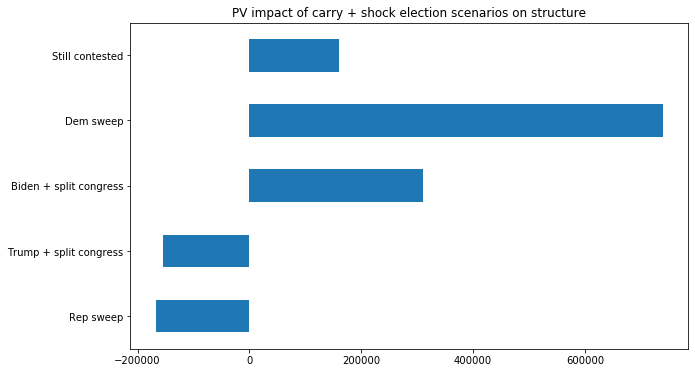

In [66]:
final_scen = {s: s_p.aggregate() - base_price for s, s_p in outcomes.items()}
pd.Series(final_scen).plot(kind='barh', figsize=(10, 6), title='PV impact of carry + shock election scenarios on structure')

### What's New
* `FXOption` used in this notebook
* Simplified backtesting - examples to come
* `BacktoTheFuturePricingContext` pricing context - combining `HistoricalPricingContext` and `CarryScenario`